<a href="https://colab.research.google.com/github/IslemAgrebi/Flight-delay-big-data-project-/blob/main/flights_delay_prediction_scikit_learn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import RandomOverSampler

In [ ]:
# import datasets
flights = pd.read_csv('flights.csv', sep=',')
planes = pd.read_csv('planes.csv', sep=',')

In [ ]:
flights.head()

,year,month,day,dep_time,dep_delay,arr_time,arr_delay,carrier,tailnum,flight,origin,dest,air_time,distance,hour,minute
0,2014,12,8,658.0,-7.0,935.0,-5.0,VX,N846VA,1780,SEA,LAX,132.0,954,6.0,58.0
1,2014,1,22,1040.0,5.0,1505.0,5.0,AS,N559AS,851,SEA,HNL,360.0,2677,10.0,40.0
2,2014,3,9,1443.0,-2.0,1652.0,2.0,VX,N847VA,755,SEA,SFO,111.0,679,14.0,43.0
3,2014,4,9,1705.0,45.0,1839.0,34.0,WN,N360SW,344,PDX,SJC,83.0,569,17.0,5.0
4,2014,3,9,754.0,-1.0,1015.0,1.0,AS,N612AS,522,SEA,BUR,127.0,937,7.0,54.0


In [ ]:
planes.head()

,tailnum,year,type,manufacturer,model,engines,seats,speed,engine
0,N102UW,1998.0,Fixed wing multi engine,AIRBUS INDUSTRIE,A320-214,2,182,NaN,Turbo-fan
1,N103US,1999.0,Fixed wing multi engine,AIRBUS INDUSTRIE,A320-214,2,182,NaN,Turbo-fan
2,N104UW,1999.0,Fixed wing multi engine,AIRBUS INDUSTRIE,A320-214,2,182,NaN,Turbo-fan
3,N105UW,1999.0,Fixed wing multi engine,AIRBUS INDUSTRIE,A320-214,2,182,NaN,Turbo-fan
4,N107US,1999.0,Fixed wing multi engine,AIRBUS INDUSTRIE,A320-214,2,182,NaN,Turbo-fan


In [ ]:
# Rename 'year' column in planes DataFrame to 'plane_year'
planes = planes.rename(columns={'year': 'plane_year'})

# Join the DataFrames on the 'tailnum' column
model_data = flights.merge(planes, on='tailnum', how='left')

model_data.head()

,year,month,day,dep_time,dep_delay,arr_time,arr_delay,carrier,tailnum,flight,...,hour,minute,plane_year,type,manufacturer,model,engines,seats,speed,engine
0,2014,12,8,658.0,-7.0,935.0,-5.0,VX,N846VA,1780,...,6.0,58.0,2011.0,Fixed wing multi engine,AIRBUS,A320-214,2.0,182.0,NaN,Turbo-fan
1,2014,1,22,1040.0,5.0,1505.0,5.0,AS,N559AS,851,...,10.0,40.0,2006.0,Fixed wing multi engine,BOEING,737-890,2.0,149.0,NaN,Turbo-fan
2,2014,3,9,1443.0,-2.0,1652.0,2.0,VX,N847VA,755,...,14.0,43.0,2011.0,Fixed wing multi engine,AIRBUS,A320-214,2.0,182.0,NaN,Turbo-fan
3,2014,4,9,1705.0,45.0,1839.0,34.0,WN,N360SW,344,...,17.0,5.0,1992.0,Fixed wing multi engine,BOEING,737-3H4,2.0,149.0,NaN,Turbo-fan
4,2014,3,9,754.0,-1.0,1015.0,1.0,AS,N612AS,522,...,7.0,54.0,1999.0,Fixed wing multi engine,BOEING,737-790,2.0,151.0,NaN,Turbo-jet


In [ ]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          10000 non-null  int64  
 1   month         10000 non-null  int64  
 2   day           10000 non-null  int64  
 3   dep_time      9952 non-null   float64
 4   dep_delay     9952 non-null   float64
 5   arr_time      9945 non-null   float64
 6   arr_delay     9925 non-null   float64
 7   carrier       10000 non-null  object 
 8   tailnum       9986 non-null   object 
 9   flight        10000 non-null  int64  
 10  origin        10000 non-null  object 
 11  dest          10000 non-null  object 
 12  air_time      9925 non-null   float64
 13  distance      10000 non-null  int64  
 14  hour          9952 non-null   float64
 15  minute        9952 non-null   float64
 16  plane_year    9354 non-null   float64
 17  type          9448 non-null   object 
 18  manufacturer  9448 non-null

In [ ]:
# Remove column 'speed'
model_data.drop(columns='speed', inplace=True)

In [ ]:
# Create the column 'plane_age' by subtracting 'plane_year' from 'year'
model_data['plane_age'] = model_data['year'] - model_data['plane_year']

In [ ]:
model_data['plane_year'].min()

0.0

In [ ]:
model_data['plane_year'].max()

2014.0

In [ ]:
model_data['plane_year'].value_counts()

,count
plane_year,
2001.0,947
2006.0,654
1999.0,650
1998.0,622
2008.0,579
2013.0,570
2007.0,532
2000.0,526
2014.0,393


In [ ]:
# Replace 0 values with NaN
model_data['plane_year'] = model_data['plane_year'].replace(0, np.nan)

In [ ]:
model_data['plane_year'].isna().sum()

654

In [ ]:
model_data.describe()

,year,month,day,dep_time,dep_delay,arr_time,arr_delay,flight,air_time,distance,hour,minute,plane_year,engines,seats,plane_age
count,10000.0,10000.00000,10000.000000,9952.000000,9952.000000,9945.000000,9925.000000,10000.000000,9925.000000,10000.000000,9952.000000,9952.000000,9346.000000,9448.000000,9448.000000,9354.000000
mean,2014.0,6.64380,15.700900,1277.115856,6.068629,1477.723680,2.253098,1369.101100,152.884232,1208.151600,12.465434,30.572448,2003.307725,1.999365,159.773920,12.405602
std,0.0,3.31916,8.895142,524.114295,28.808608,526.593652,31.074919,1498.714574,72.865629,656.859902,5.246263,17.985333,6.552639,0.032529,54.352204,58.929220
min,2014.0,1.00000,1.000000,1.000000,-19.000000,1.000000,-58.000000,2.000000,20.000000,93.000000,0.000000,0.000000,1959.000000,1.000000,2.000000,0.000000
25%,2014.0,4.00000,8.000000,831.000000,-5.000000,1122.000000,-12.000000,407.000000,102.000000,689.000000,8.000000,15.000000,1999.000000,2.000000,148.500000,6.000000
50%,2014.0,7.00000,16.000000,1216.000000,-2.000000,1517.000000,-4.000000,705.000000,129.000000,991.000000,12.000000,31.000000,2003.000000,2.000000,149.000000,11.000000
75%,2014.0,9.00000,23.000000,1720.000000,5.000000,1916.000000,7.000000,1768.000000,200.000000,1660.000000,17.000000,47.000000,2008.000000,2.000000,182.000000,15.000000
max,2014.0,12.00000,31.000000,2400.000000,886.000000,2400.000000,900.000000,6527.000000,409.000000,2724.000000,24.000000,59.000000,2014.000000,3.000000,400.000000,2014.000000


In [ ]:
# Create 'is_late' column by checking if 'arr_delay' is greater than 15min
model_data['is_late'] = model_data['arr_delay'] > 15

# Convert 'is_late' to an integer and store it in a new column 'label'
model_data['label'] = model_data['is_late'].astype(int)

In [ ]:
model_data.columns

Index(['year', 'month', 'day', 'dep_time', 'dep_delay', 'arr_time',
       'arr_delay', 'carrier', 'tailnum', 'flight', 'origin', 'dest',
       'air_time', 'distance', 'hour', 'minute', 'plane_year', 'type',
       'manufacturer', 'model', 'engines', 'seats', 'engine', 'plane_age',
       'is_late', 'label'],
      dtype='object')

In [ ]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          10000 non-null  int64  
 1   month         10000 non-null  int64  
 2   day           10000 non-null  int64  
 3   dep_time      9952 non-null   float64
 4   dep_delay     9952 non-null   float64
 5   arr_time      9945 non-null   float64
 6   arr_delay     9925 non-null   float64
 7   carrier       10000 non-null  object 
 8   tailnum       9986 non-null   object 
 9   flight        10000 non-null  int64  
 10  origin        10000 non-null  object 
 11  dest          10000 non-null  object 
 12  air_time      9925 non-null   float64
 13  distance      10000 non-null  int64  
 14  hour          9952 non-null   float64
 15  minute        9952 non-null   float64
 16  plane_year    9346 non-null   float64
 17  type          9448 non-null   object 
 18  manufacturer  9448 non-null

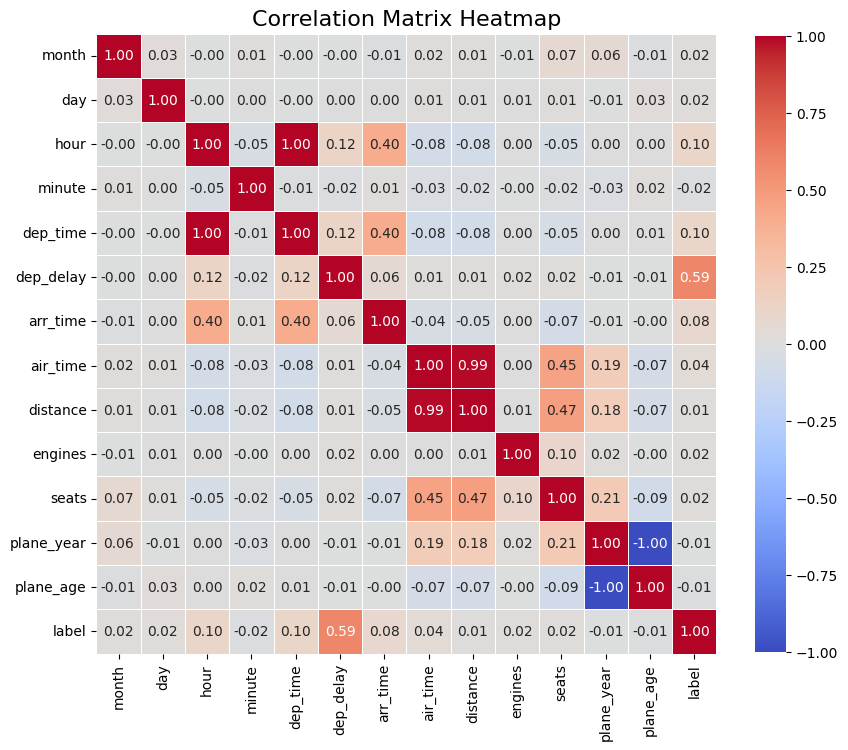

In [ ]:
data = model_data[['month', 'day', 'hour', 'minute',
                   'dep_time', 'dep_delay', 'arr_time', 'air_time', 'distance',
                  'engines', 'seats','plane_year', 'plane_age','label']]

# Calculate the correlation matrix
correlation_matrix = data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 10))

# Draw the heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True,
            cbar_kws={"shrink": .8}, linewidths=0.5)

# Add title
plt.title('Correlation Matrix Heatmap', fontsize=16)

# Show the plot
plt.show()

In [ ]:
model_data.isna().sum()

,0
year,0
month,0
day,0
dep_time,48
dep_delay,48
arr_time,55
arr_delay,75
carrier,0
tailnum,14
flight,0


In [ ]:
model_data['label'].value_counts()

,count
label,
0,8489
1,1511


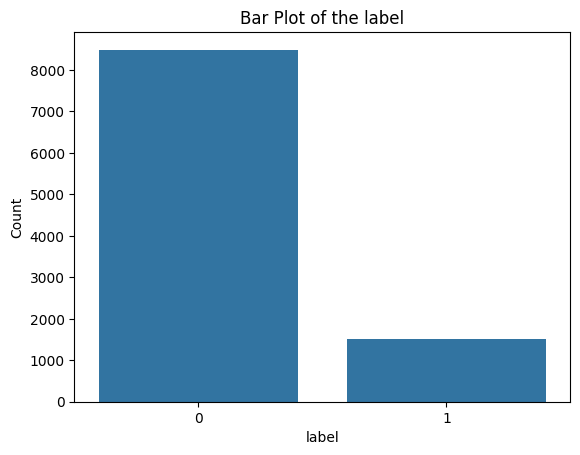

In [ ]:
sns.countplot(data=model_data, x=model_data['label'])
plt.title("Bar Plot of the label")
plt.xlabel('label')
plt.ylabel('Count')
plt.xticks()
plt.show()

In [ ]:
# Remove rows with missing values in specific columns
model_data = model_data.dropna(subset=['arr_delay', 'dep_delay', 'engine', 'air_time', 'plane_year'])

In [ ]:
model_data.isna().sum().sum()

0

In [ ]:
import math
abs(data.corr(method='pearson')['label']).sort_values(ascending=False)


,label
label,1.000000
dep_delay,0.586834
hour,0.103801
dep_time,0.103230
arr_time,0.083381
air_time,0.044846
seats,0.020133
minute,0.019586
month,0.019283
day,0.017357


In [ ]:
# Define preprocessing steps
categorical_features = ["carrier", "dest", "origin", "engine"]
numeric_features = ["dep_delay", "dep_time", "air_time", "arr_time"]

# Define features and target
X = model_data[["carrier", "dest", "origin", "engine", "dep_delay", "dep_time", "air_time", "arr_time"]]
y = model_data['label']

# Oversample the minority class
oversampler = RandomOverSampler(sampling_strategy='auto')
X_balanced, y_balanced = oversampler.fit_resample(X, y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

In [ ]:
y.value_counts()

,count
label,
0,7903
1,1392


In [ ]:
y_balanced.value_counts()

,count
label,
0,7903
1,7903


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, RobustScaler, OneHotEncoder
from sklearn.feature_selection import SelectPercentile, f_classif, chi2
import joblib


# Define preprocessing steps for numerical and categorical features
num_transformer = Pipeline(steps=[
                                  ('scaler', RobustScaler()),
                                  ('transformer', PowerTransformer(method='yeo-johnson', standardize=False)),
                                  ('selector', SelectPercentile(f_classif, percentile=80))])

cat_transformer = Pipeline(steps=[
                                  ("encoder", OneHotEncoder()),
                                  ("selector", SelectPercentile(chi2, percentile=80))])

# Combine preprocessing steps for numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numeric_features),
        ('cat', cat_transformer, categorical_features)])

# Fit and apply the data preparation pipeline
preprocessor.fit(X_train, y_train)

# Save the preprocessor pipeline
joblib.dump(preprocessor, 'preprocessor.joblib')

# Apply the preprocessor to the training and testing data
X_train_prepared = preprocessor.transform(X_train)
X_test_prepared = preprocessor.transform(X_test)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV

In [ ]:
# Define classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(n_jobs=-1, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_jobs=-1),
    'Support Vector Machine': SVC(probability=True, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_jobs=-1, random_state=42),
    'XGBoost': XGBClassifier(n_jobs=-1, random_state=42)
}

# Define hyperparameters grid for each classifier
params_grid = {
    'Logistic Regression': {'C': [0.1, 1, 10]},
    'K-Nearest Neighbors': {'n_neighbors': [3, 5, 7]},
    'Support Vector Machine': {'C': [0.1, 1, 10], 'gamma': [0.1, 1, 'scale']},
    'Decision Tree': {'max_depth': [None, 5, 10, 20]},
    'Random Forest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 5, 10]},
    'XGBoost': {'n_estimators': [50, 100, 200], 'max_depth': [None, 5, 10], 'learning_rate': [0.01, 0.1, 0.3]}
}

# Perform k-fold cross-validation and hyperparameter tuning for each classifier
best_estimators = {}
for clf_name, clf in classifiers.items():
    print(f"Working on {clf_name}...")
    params = params_grid[clf_name]
    grid_search = GridSearchCV(clf, params, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_prepared, y_train)
    print(f"Best parameters for {clf_name}: {grid_search.best_params_}")
    print(f"Best cross-validation score for {clf_name}: {grid_search.best_score_:.4f}")

    # Retrain the best estimator on the entire training set
    best_estimators[clf_name] = grid_search.best_estimator_
    best_estimators[clf_name].fit(X_train_prepared, y_train)


Working on Logistic Regression...
Best parameters for Logistic Regression: {'C': 0.1}
Best cross-validation score for Logistic Regression: 0.8558
Working on K-Nearest Neighbors...
Best parameters for K-Nearest Neighbors: {'n_neighbors': 3}
Best cross-validation score for K-Nearest Neighbors: 0.9117
Working on Support Vector Machine...
Best parameters for Support Vector Machine: {'C': 10, 'gamma': 1}
Best cross-validation score for Support Vector Machine: 0.9044
Working on Decision Tree...
Best parameters for Decision Tree: {'max_depth': None}
Best cross-validation score for Decision Tree: 0.9488
Working on Random Forest...
Best parameters for Random Forest: {'max_depth': None, 'n_estimators': 100}
Best cross-validation score for Random Forest: 0.9676
Working on XGBoost...
Best parameters for XGBoost: {'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 200}
Best cross-validation score for XGBoost: 0.9670


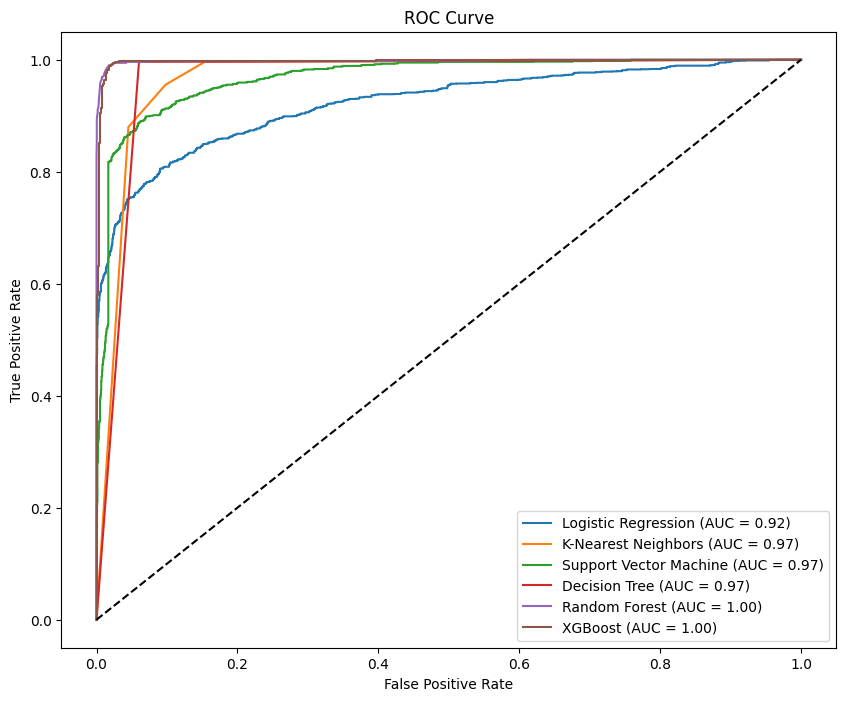

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc

# Evaluate all models
results = {}
for clf_name, clf in best_estimators.items():
    y_pred = clf.predict(X_test_prepared)
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test_prepared)[:,1])
    roc_auc = auc(fpr, tpr)
    results[clf_name] = {'Accuracy': accuracy, 'Confusion Matrix': conf_matrix, 'FPR': fpr, 'TPR': tpr, 'AUC ROC': roc_auc}

# Plot ROC curves and compute AUC ROC for all models
plt.figure(figsize=(10, 8))
for clf_name, result in results.items():
    fpr = result['FPR']
    tpr = result['TPR']
    auc_roc = result['AUC ROC']
    plt.plot(fpr, tpr, label=f'{clf_name} (AUC = {auc_roc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

Logistic Regression ====> Accuracy=0.8551244200759174
K-Nearest Neighbors ====> Accuracy=0.9285111767186841
Support Vector Machine ====> Accuracy=0.9101644875579924
Decision Tree ====> Accuracy=0.9677351328553353
Random Forest ====> Accuracy=0.9801771404470687
XGBoost ====> Accuracy=0.9837621256853648
Best model based on accuracy: XGBoost with accuracy 0.9837621256853648

-----------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      2388
           1       0.97      1.00      0.98      2354

    accuracy                           0.98      4742
   macro avg       0.98      0.98      0.98      4742
weighted avg       0.98      0.98      0.98      4742


-----------------------------------------



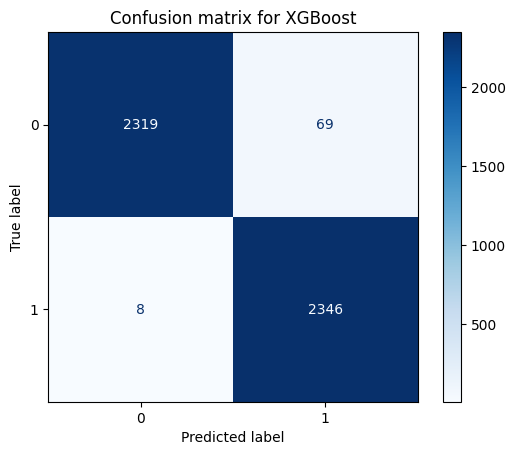

['best_model.pkl']

In [ ]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import joblib
import matplotlib.pyplot as plt

# Print the accuracy for each model
for clf_name, clf in best_estimators.items():
    print(f"{clf_name} ====> Accuracy={results[clf_name]['Accuracy']}")

# Select the best model based on accuracy
best_model_name = max(results, key=lambda x: results[x]['Accuracy'])
best_model = best_estimators[best_model_name]
print(f"Best model based on accuracy: {best_model_name} with accuracy {results[best_model_name]['Accuracy']}")
print()
print('-----------------------------------------')
print()

# Make predictions using the best model
y_pred = best_model.predict(X_test_prepared)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))
print()
print('-----------------------------------------')
print()


# Plot confusion matrix for the best model
disp = ConfusionMatrixDisplay(confusion_matrix=results[best_model_name]['Confusion Matrix'], display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title(f'Confusion matrix for {best_model_name}')
plt.show()

# Deploy the best model
joblib.dump(best_model, 'best_model.pkl')